In [1]:
import numpy as np



# file is saved using        np.savetxt("pointcloud_data.txt", points)

# I want to read it as an array

# points = np.loadtxt("pointcloud_data.txt")
points = np.loadtxt("lidar_points_xyz.csv", delimiter=",")
print("Loaded point cloud data:", points)

Loaded point cloud data: [[            nan             nan             nan]
 [ 1.12224370e-07  4.41666250e+04  2.36230895e-41]
 [ 4.58280650e-41  4.58280650e-41  9.18354962e-41]
 ...
 [-1.58593446e-01  1.29433212e+01  8.40000000e+01]
 [ 4.41666484e+04  5.07561746e-18  3.38173152e-08]
 [ 2.34283090e-41  8.74826147e-39 -6.25750139e-35]]


In [2]:

# get the spherical representation of the point cloud
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arctan2(y, x)  # azimuthal angle
theta[theta<0] += 2*np.pi  # convert to [0, 2pi]
phi = np.arccos(z / r)    # polar angle
phi_deg = np.degrees(phi)
theta_deg = np.degrees(theta)
spherical_points = np.vstack((r, theta, phi)).T
spherical_points_deg = np.vstack((r, theta_deg, phi_deg)).T


r_reshaped = r.reshape(900, -1).T  # reshape to original lidar scan shape if known
# flip vertically
r_reshaped2 = np.flipud(r_reshaped).copy()

theta_reshaped = theta_deg.reshape(900, -1).T
print(theta_reshaped.shape)
theta_reshaped = np.flipud(theta_reshaped).copy()
# theta_reshaped_slice = theta_reshaped[:, 450]
phi_reshaped = phi_deg.reshape(900, -1).T

ValueError: cannot reshape array of size 134940 into shape (900,newaxis)

In [3]:
# plot a line plot of thetas

import matplotlib.pyplot as plt
for i in range(90):
    plt.plot(theta_reshaped[i, :], label=f"Row {i}")
plt.xlabel("Point Index")
plt.ylabel("Theta (degrees)")
plt.title("Azimuthal Angle (Theta) across a Lidar Scan Line")
plt.grid()
plt.show()

for i in range(90):
    plt.plot(phi_reshaped[i, :], label=f"Row {i}")
plt.xlabel("Point Index")
plt.ylabel("Phi (degrees)")
plt.title("Polar Angle (Phi) across a Lidar Scan Line")
plt.grid()
plt.show()

# all nan values to be set to 700
theta_reshaped[np.isnan(theta_reshaped)] = 700
# find the place where theta is closes to 0 degrees
center_indices = np.argmin(np.abs(theta_reshaped - 200), axis=1) - 404
print(center_indices)
center_indices = -center_indices
# list to tuple
center_indices = tuple(center_indices.tolist())
print("Center indices (closest to 0 degrees):", center_indices)

# roll by the center indices
# for i in range(90):
#     # r_reshaped2[i, :] = np.roll(r_reshaped2[i, :], -center_indices[i])
#     theta_reshaped[i, :] = np.roll(theta_reshaped[i, :], -center_indices[i])

# roll as a tensor
import torch
theta_reshaped_torch = torch.zeros_like(torch.tensor(theta_reshaped))
theta_reshaped_torch = torch.tensor(theta_reshaped)

theta_reshaped_rolled = torch.zeros_like(theta_reshaped_torch)
r_reshaped_rolled = torch.zeros_like(torch.tensor(r_reshaped2))
print(theta_reshaped.shape, len(center_indices))
for i in range(90):
    theta_reshaped_rolled[i, :] = torch.roll(theta_reshaped_torch[i, :], center_indices[i])
    r_reshaped_rolled[i, :] = torch.roll(torch.tensor(r_reshaped2)[i, :], center_indices[i])

theta_reshaped_np = theta_reshaped_rolled.numpy()
r_reshaped_np = r_reshaped_rolled.numpy()
theta_reshaped[theta_reshaped > 361] = np.nan  # set back to nan
theta_reshaped_np[theta_reshaped_np > 361] = np.nan  # center around 0 degrees
# plot a line plot of thetas after centering
for i in range(90):
    plt.plot(theta_reshaped_np[i, :], label=f"Row {i}")
plt.xlabel("Point Index")
plt.ylabel("Theta (degrees)")
plt.title("Azimuthal Angle (Theta) across a Lidar Scan Line (Centered)")
plt.grid()
plt.show()

print(r_reshaped_np.shape)
# show the r_reshaped_np as an image
plt.imshow(r_reshaped_np, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (r)')
plt.title('Lidar Scan Distance after Centering')
plt.xlabel('Point Index')
plt.ylabel('Scan Line Index')
plt.show()

plt.imshow(r_reshaped2, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (r)')
plt.title('Lidar Scan Distance (Original)')
plt.xlabel('Point Index')
plt.ylabel('Scan Line Index')

NameError: name 'theta_reshaped' is not defined

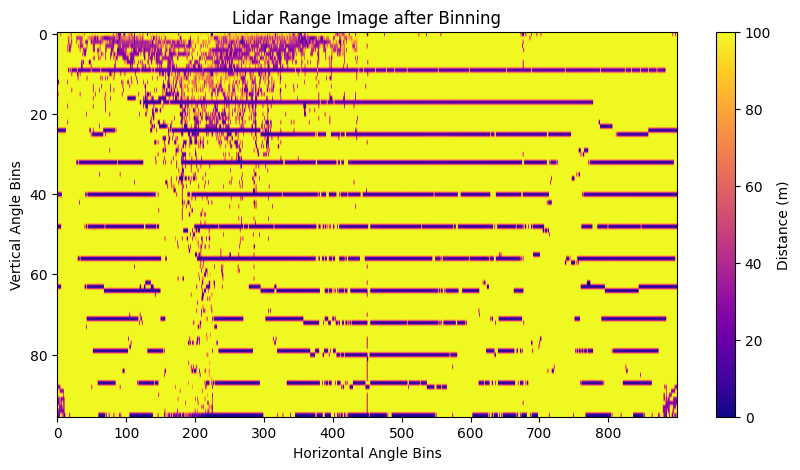

NameError: name 'r_reshaped2' is not defined

<Figure size 1000x500 with 0 Axes>

In [4]:

# I want to divide 0 to 90 degrees phi into 96 buckets and 0 to 360 degrees theta into 900 buckets
phi_bins = np.linspace(0, 90, 97)  # 96 bins
theta_bins = np.linspace(0, 360, 901)  # 900 bins

# digitize phi and theta to get bin indices
phi_indices = np.digitize(phi_deg, phi_bins) - 1  # subtract 1 to get 0-based index
theta_indices = np.digitize(theta_deg, theta_bins) - 1  # subtract 1 to get 0-based index

# create an empty grid to hold the min r values
grid_r = np.full((96, 900), 100.0)
# populate the grid with min r values for each bin
for i in range(len(r)):
    p_idx = phi_indices[i]
    t_idx = theta_indices[i]
    if 0 <= p_idx < 96 and 0 <= t_idx < 900:
        if r[i] < grid_r[p_idx, t_idx]:
            grid_r[p_idx, t_idx] = r[i]
r_reshaped = grid_r

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(r_reshaped, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Lidar Range Image after Binning')
plt.xlabel('Horizontal Angle Bins')
plt.ylabel('Vertical Angle Bins')
plt.show()

# plot r_reshaped2
plt.figure(figsize=(10, 5))
plt.imshow(r_reshaped2, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Lidar Range Image Original Shape')
plt.xlabel('Horizontal Angle')
plt.ylabel('Vertical Angle')
plt.show()









In [ ]:
max_range = 100.0
r_reshaped = np.where(np.isnan(r_reshaped), max_range, r_reshaped)

r_reshaped[r_reshaped>10] = 10.0
r_reshaped[r_reshaped<0.35] = 10.0
r_reshaped = r_reshaped / 10.0


# show as a range image of r_reshaped using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(r_reshaped, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Lidar Range Image')
plt.xlabel('Horizontal Angle')
plt.ylabel('Vertical Angle')
plt.show()

print(theta_reshaped[:, 450])

# minpool such that we get 16 x 20 grid

import torch
r_reshaped_torch = torch.tensor(r_reshaped).unsqueeze(0).unsqueeze(0)  # add batch and channel dims
import torch.nn.functional as F
# minpool such that the result is 16 x 20
print("Original shape:", r_reshaped_torch.shape)
pooled = F.max_pool2d(-r_reshaped_torch, kernel_size=(r_reshaped_torch.shape[2]//16, r_reshaped_torch.shape[3]//20))
print(pooled.shape)
pooled = -pooled.squeeze().numpy()
print("Pooled shape:", pooled.shape)

# plot
plt.figure(figsize=(8, 6))
plt.imshow(pooled, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Pooled Lidar Range Image (16x20)')
plt.xlabel('Horizontal Bins')
plt.ylabel('Vertical Bins')
plt.show()

# print min of the pooled
print("Min distance in pooled image:", np.min(pooled))

Using device: cpu
Point cloud data types:
r: torch.float32
theta: torch.float32
phi: torch.float32
flat_indices: torch.int64
azimuth_bins: <class 'int'>
elevation_bins: <class 'int'>
pooled shape: (16, 20)
Scatter reduce took 0.0005 seconds


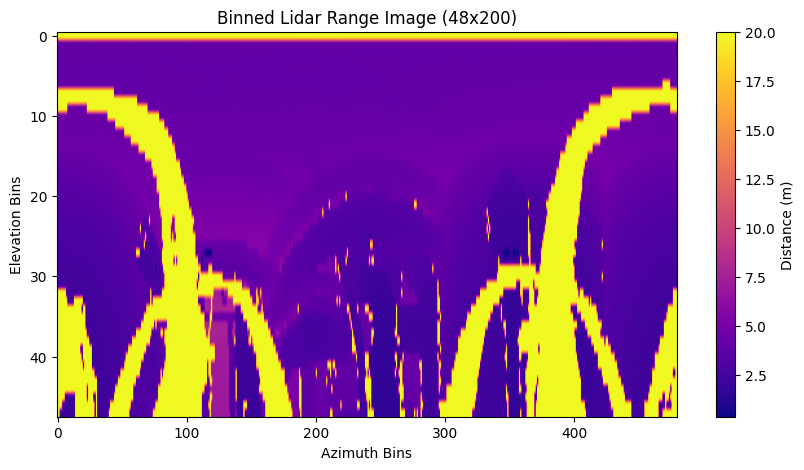

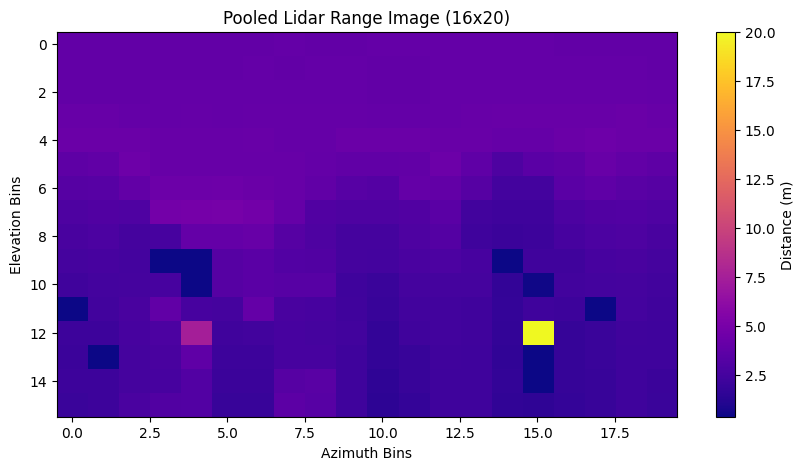

ValueError: cannot reshape array of size 67914 into shape (900,newaxis)

In [13]:
import numpy as np
import torch.nn.functional as F


# file is saved using        np.savetxt("pointcloud_data.txt", points)

# I want to read it as an array

# points = np.loadtxt("pointcloud_data.txt")
points = np.loadtxt("lidar_points_xyz.csv", delimiter=",")
# print("Loaded point cloud data:", points)

# set torch device to cuda
import torch
device = torch.device("cpu")#cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# file is saved using        np.savetxt("pointcloud_data.txt", points)

# I want to read it as an array

# loaded_data = np.loadtxt("pointcloud_data.txt")
loaded_data = np.loadtxt("lidar_points_xyz.csv", delimiter=",")

# get the spherical representation of the point cloud
x = loaded_data[:, 0]
y = loaded_data[:, 1]
z = loaded_data[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arctan2(y, x)  # azimuthal angle
theta[theta<0] += 2*np.pi  # convert to [0, 2pi]
phi = np.arccos(z / r)    # polar angle
phi_deg = np.degrees(phi)
theta_deg = np.degrees(theta)



# set all r nan to 700
r[np.isnan(r)] = 700.0  # set nan r values to a large number
r[r>20.0] = 20.0
r[r<0.35] = 20.0


theta[np.isnan(theta)] = 10*np.pi  # set nan theta values to 2pi
phi[np.isnan(phi)] = 5*np.pi/2  # set nan phi values to pi/2

spherical_points = np.vstack((r, theta, phi)).T
spherical_points_deg = np.vstack((r, theta_deg, phi_deg)).T

points = torch.tensor(spherical_points).to(torch.float32).to(device)  # (N, 3) with columns (r, theta, phi)

# Bin edges
azimuth_bins = 480
elevation_bins = 48
# azimuth goes from 0 to 2pi
azimuth_idx = (points[:, 1] / (2 * torch.pi) * azimuth_bins).long()
# elevation goes from 0 to pi
elevation_idx = (points[:, 2] / (torch.pi/2) * elevation_bins).long()


# Clamp indices to avoid out-of-bounds
azimuth_idx = torch.clamp(azimuth_idx, 0, azimuth_bins - 1).to(device)
elevation_idx = torch.clamp(elevation_idx, 0, elevation_bins - 1).to(device)

# Initialize bins with infinity
bins = torch.full((azimuth_bins, elevation_bins), float('inf')).to(device)

# Flatten the indices for scatter_reduce
flat_indices = azimuth_idx * elevation_bins + elevation_idx



# print all dtypes
print("Point cloud data types:")
print("r:", points[:, 0].dtype)
print("theta:", points[:, 1].dtype)
print("phi:", points[:, 2].dtype)
print("flat_indices:", flat_indices.dtype)
print("azimuth_bins:", type(azimuth_bins))
print("elevation_bins:", type(elevation_bins))

import time
start_time = time.time()
input_tensor = torch.full((azimuth_bins * elevation_bins,), 20.0).to(device)
# Use scatter_reduce to compute the minimum r per bin
bins = torch.scatter_reduce(
    input=input_tensor,
    dim=0,
    index=flat_indices,
    src=points[:, 0],
    reduce='amin',
    include_self=False
)

# Reshape to (48, 200)
bins = bins.view(azimuth_bins, elevation_bins)
# minpooled such that we get 16 x 20 grid
bins2 = bins.T.unsqueeze(0).unsqueeze(0)  # add batch and channel dims
pooled = F.max_pool2d(-bins2, kernel_size=(bins2.shape[2]//16, bins2.shape[3]//20))
pooled = -pooled.squeeze().cpu().numpy()
# torch.cuda.synchronize()
end_time = time.time()
print("pooled shape:", pooled.shape)
print(f"Scatter reduce took {end_time - start_time:.4f} seconds")

# visualize bins
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(bins.cpu().numpy().T, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Binned Lidar Range Image (48x200)')
plt.xlabel('Azimuth Bins')
plt.ylabel('Elevation Bins')
plt.show()



plt.figure(figsize=(10, 5))
plt.imshow(pooled, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Pooled Lidar Range Image (16x20)')
plt.xlabel('Azimuth Bins')
plt.ylabel('Elevation Bins')
plt.show()


# visualize original image
r_reshaped = r.reshape(900, -1).T  # reshape to original lidar scan shape if known
r_reshaped = np.flipud(r_reshaped).copy()
plt.figure(figsize=(10, 5))
plt.imshow(r_reshaped, cmap='plasma', aspect='auto')
plt.colorbar(label='Distance (m)')
plt.title('Original Lidar Range Image')
plt.xlabel('Horizontal Angle')
plt.ylabel('Vertical Angle')
plt.show()


